In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.stats import mad_std

In [60]:
from glob import glob

# Open PDCSAP light curves
paths = glob('../TESSellate/downloads/*.npy')

Measure the typical standard deviation of the TESS TOI PDCSAP light curves

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


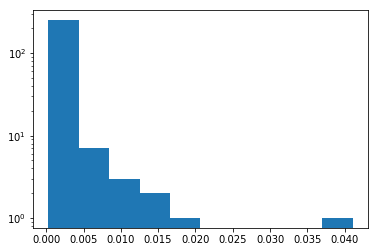

In [65]:
stdevs = []
for path in paths: 
    times, fluxes = np.load(path).T
    sort = np.argsort(times)
    times = times[sort]
    fluxes = fluxes[sort]
    
    split_times = []
    split_fluxes = []
    stdev = []
    diff_times = np.diff(times) > 2.5/60/24
    
    if np.count_nonzero(diff_times) > 0: 
        splits = np.concatenate([[0], np.argwhere(diff_times).T[0], [len(times)-1]])
        for i in range(1, len(splits)):
            t = times[splits[i-1]:splits[i]]
            f = fluxes[splits[i-1]:splits[i]] / np.nanmedian(fluxes[splits[i-1]:splits[i]])
            stdev.append(mad_std(f, ignore_nan=True))
            
    stdevs.append(np.nanmean(stdev))
    
stdevs = np.array(stdevs)
np.save('data/toi_stdevs.npy', stdevs)
plt.hist(stdevs, log=True);

In [68]:

half_max_paths = glob('data/half_solar_max/residuals_*')
max_paths = glob('data/solar_max/residuals_*')
more_max_paths = glob('data/1400/residuals_*')

half_max_residuals = []
for path in half_max_paths:     
    half_max_residuals.append(np.load(path))

max_residuals = []
for path in max_paths:     
    max_residuals.append(np.load(path))

more_max_residuals = []
for path in more_max_paths:     
    more_max_residuals.append(np.load(path))
    
half_max_residuals = np.concatenate(half_max_residuals)
max_residuals = np.concatenate(max_residuals)
more_max_residuals = np.concatenate(more_max_residuals)

(0, 0.0035)

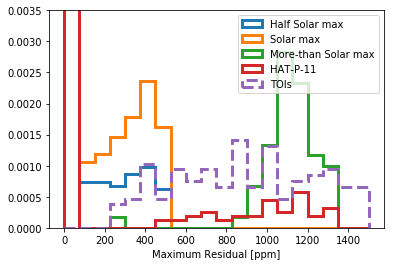

In [74]:
hat11 = np.load('data/hat11_residuals.npy')
histprops = dict(density=True, histtype='step', lw=3, range=[0, 1500])
plt.hist(half_max_residuals * 1e6, 20, label='Half Solar max', **histprops);
plt.hist(max_residuals * 1e6, 20, label='Solar max', **histprops);
plt.hist(more_max_residuals * 1e6, 20, label='More-than Solar max', **histprops);
plt.hist(hat11 * 1e6, 20, label='HAT-P-11', **histprops)

plt.hist(stdevs * 1e6, 20, label='TOIs', ls='--', **histprops)

plt.legend()
plt.xlabel('Maximum Residual [ppm]')
plt.ylim([0, 0.0035])

How often would the residual spot occultations be detectable given the noise distribution of TESS TOIs?

In [97]:
n_draws = 1000000

threshold_for_detection = 3
tess_noise_std = stdevs[np.random.randint(0, len(stdevs), size=n_draws)]

def randint(high, n_draws=n_draws):
    return np.random.randint(0, high, size=n_draws)

def fraction_detected(cond): 
    return np.count_nonzero(cond)/cond.shape[0]

half_max_detected = half_max_residuals[randint(len(half_max_residuals))] > threshold_for_detection * tess_noise_std
half_max_detected_fraction = fraction_detected(half_max_detected)

max_detected = max_residuals[randint(len(max_residuals))] > threshold_for_detection * tess_noise_std
max_detected_fraction = fraction_detected(max_detected)

more_max_detected = more_max_residuals[randint(len(more_max_residuals))] > threshold_for_detection * tess_noise_std
more_max_detected_fraction = fraction_detected(more_max_detected)

In [98]:
half_max_detected_fraction, max_detected_fraction, more_max_detected_fraction

(0.0, 0.0, 0.030277)

In [131]:
# 0.5 mmag -> flux [ppm]
half_mmag = (10**((0.5e-3) / 2.5) - 1) * 1e6
print(half_mmag)

460.6230728403382


Get cumulative Kepler [KOI list](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative)

In [100]:
from astropy.table import Table

koi_table = Table.read('data/cumulative_2019.07.05_01.52.59.votable')

In [143]:
shortlist = koi_table[(koi_table['koi_steff'] < 6000) & (koi_table['koi_depth'] > half_mmag) & (koi_table['koi_kepmag'] < 14.2)]

In [144]:
n_detected_kepler = (int(b'Kepler-17 b' in shortlist['kepler_name'].data.data) + 
                     int(b'Kepler-3 b' in shortlist['kepler_name'].data.data))
n_searched_kepler = len(shortlist)

fraction_kepler_observed = n_detected_kepler/n_searched_kepler

print(fraction_kepler_observed)

0.0025575447570332483


$$ f_\text{observed} = f_\text{total} \cdot f_\text{detectable} $$
so
$$ f_\text{total} = f_\text{observed} \cdot  f_\text{detectable}^{-1}   $$

In [145]:
f_total = fraction_kepler_observed / more_max_detected_fraction

print(f_total)

0.08447153803326778
